In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - power_spectrum.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Calculate the power spectrum of Gaia DR2 velocity fluctuations
'''

__author__ = "James Lane"

In [2]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util
import ast1501.fourier
import ast1501.df

In [3]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rc('font', size=12)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Meta

## Future work
- Fix darn power spectrum normalization. Making good progress!
- Figure out why the 1-D case has such wierd velocities

## Information
- See the `ast1501.fourier` module
- Bovy RC stuff https://github.com/jobovy/apogee-rc/tree/master/py
- Check Bovy paper http://iopscience.iop.org/article/10.1088/0004-637X/800/2/83/pdf
- Ginsburg FFT stuff https://github.com/keflavich/agpy/tree/master/AG_fft_tools

# Prepare

## Functions

In [4]:
def plot_grid(hist, vmin, vmax, extent, low_N_mask, no_N_mask, cmap, plot_low_N_mask=True):

    # Plot the image. Rotate to account for histogram => plotting grid
    img = ax.imshow(np.rot90(hist), interpolation='nearest',
                    extent=extent, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Add the image masks. Assumes same geometry as hist.
    if plot_low_N_mask == True:
        img_mask = ax.imshow(np.rot90(low_N_mask), interpolation='nearest',
                             extent=extent)
    img_mask = ax.imshow(np.rot90(no_N_mask), interpolation='nearest',
                         extent=extent)

    # Colorbar
    cbar = plt.colorbar(img)
    
    # Add the sun and it's orbit
    ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black', s=256)
    for R in [5,6,7,8,9,10,11,12,13,14,15]:
        if R == 8:
            orbit_circle = plt.Circle((0, 0), R, edgecolor='Black', facecolor='None', linewidth=1)
        else:
            orbit_circle = plt.Circle((0, 0), R, edgecolor='Black', facecolor='None', linewidth=0.5)
        ##ie
        ax.add_artist(orbit_circle)
    ###i
    
    # Decorate
    ax.set_xlabel(r'X$_{GC}$ [kpc]')
    ax.set_ylabel(r'Y$_{GC}$ [kpc]')
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)
    ax.tick_params(direction='in', top='on', right='on')
    
    return fig, ax, cbar
#def

## Load data
Load the precut AstroNN catalog and apply a cut on the galactocentric $Z$, then convert values to galactocentric coordinates and velocities.

In [5]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [6]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [7]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
pmll = data_low_z['PM_LL']
pmbb = data_low_z['PM_BB']
gc_x = data_low_z['X']
gc_y = data_low_z['Y']
gc_z = data_low_z['Z']
gc_vx = data_low_z['VX']
gc_vy = data_low_z['VY']
gc_vz = data_low_z['VZ']

In [8]:
### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = -np.sin(gc_phi)*gc_vx + np.cos(gc_phi)*gc_vy

## Potential and DF

In [9]:
### Make MWPotential2014
mwpot = potential.MWPotential2014

# Velocity dispersions in km/s
sigma_vR = 46/1.5
sigma_vT = 40/1.5
sigma_vZ = 28/1.5

# Action angle coordinates and the DF
qdf_aA= actionAngleAdiabatic(pot=potential.MWPotential2014, c=True)
qdf = df.quasiisothermaldf( hr= 2*apu.kpc,
                            sr= sigma_vR*(apu.km/apu.s),
                            sz= sigma_vZ*(apu.km/apu.s),
                            hsr= 9.8*(apu.kpc),
                            hsz= 7.6*(apu.kpc),
                            pot= potential.MWPotential2014, 
                            aA= qdf_aA)

## Fix grid parameters
Decide on the spacing parameters for the velocity grid

In [10]:
# Bins per dimension
n_xbins = 20
n_ybins = 30

# Ranges
x_hi = -5
x_lo = -15
y_hi = 10
y_lo = -5
bin_range = [ [x_lo,x_hi], [y_lo,y_hi] ]

# Deltas
dx = (x_hi-x_lo)/n_xbins
dy = (y_hi-y_lo)/n_ybins

print('dx = '+str(dx)+' kpc, dy = '+str(dy)+' kpc')

dx = 0.5 kpc, dy = 0.5 kpc


# Calculate MWPotential2014 Velocity Field

In [11]:
# Galactocentric coordinate grid
gcx_range = np.arange(x_lo,x_hi,dx) + (dx/2)
gcy_range = np.arange(y_lo,y_hi,dy) + (dy/2)
gcx_range_2d, gcy_range_2d = np.meshgrid(gcx_range, gcy_range, indexing='ij')

# Arrays to hold the velocity fields
vr_field = np.zeros((n_xbins,n_ybins))
vt_field = np.zeros((n_xbins,n_ybins))
svr_field = np.zeros((n_xbins,n_ybins))
svt_field = np.zeros((n_xbins,n_ybins))

# Set velocity deltas and range
dvT = 10.
dvR = 10.
vR_low = -5*sigma_vR
vR_hi = 5*sigma_vR
vT_low = -5*sigma_vT+210
vT_hi = 5*sigma_vT+210

# Generate the velocity distribution and DF arrays
df0, dfp, vR_range, vT_range = ast1501.df.gen_vRvT_1D(dvT, dvR, vR_low, vR_hi, vT_low, vT_hi, verbose=1)

# DF is axisymmetric so just do a grid of radii and then match to 
# the X-Y bins
# Determine the minimum and maximum radius range
R_min = np.min( np.sqrt( np.square(gcx_range_2d) + np.square(gcy_range_2d) ) )
R_max = np.max( np.sqrt( np.square(gcx_range_2d) + np.square(gcy_range_2d) ) )

# Make a grid of radii between those ranges
R_range = np.linspace(R_min,R_max,num=100)
R_range_vt = np.zeros_like(R_range)
R_range_vr = np.zeros_like(R_range)
R_range_svt = np.zeros_like(R_range)
R_range_svr = np.zeros_like(R_range)

# print('R Range')
# print(R_range)

837 independent velocities
31 Between vR=[-153.0,147.0]
31 Between vR=[77.0,337.0]


In [12]:
make_new = False

if make_new:
    ## Evaluate the DF on the radial grid
    for i in tqdm_nb(range(len(R_range))):

        # First make an array for the DF
        df = np.zeros( ( len(vR_range),len(vT_range) ) ) 

        # Loop over the velocities
        for j in range(len(vR_range)):
            for k in range(len(vT_range)):

                # Compute the DF
                o = orbit.Orbit(vxvv=[R_range[i]*apu.kpc,
                                      vR_range[j]*apu.km/apu.s,
                                      vT_range[k]*apu.km/apu.s])
                df[j,k] = qdf(o)
            ###k
        ###j

        # Now calculate the density and the moments
        dens = np.sum(df) * dvR * dvT # Units of 1/kpc**2
        vR_avg = (1/dens) * np.sum( np.sum(df, axis=1) * vR_range ) * dvR * dvT
        vT_avg = (1/dens) * np.sum( np.sum(df, axis=0) * vT_range ) * dvR * dvT
        vR_std = np.sqrt((1/dens) * np.sum( np.sum(df, axis=1) * np.square( vR_avg - vR_range ) ) * dvR * dvT)
        vT_std = np.sqrt((1/dens) * np.sum( np.sum(df, axis=0) * np.square( vT_avg - vT_range ) ) * dvR * dvT)

        R_range_vr[i] = vR_avg
        R_range_vt[i] = vT_avg
        R_range_svr[i] = vR_std
        R_range_svt[i] = vT_std
    ###i
else:
    R_range,R_range_vt,R_range_vr,R_range_svt,R_range_svr = np.load('./data/MW_R_vR_vT.npy')
    print('Rmin: '+str(R_range[0]))
    print('Rmax: '+str(R_range[-1]))
    print('NR: '+str(len(R_range)))
    
# Now save this grid
np.save('./data/MW_R_vR_vT.npy', np.array([R_range,R_range_vt,R_range_vr,R_range_svt,R_range_svr]))

Rmin: 5.25594901040716
Rmax: 17.681204710086924
NR: 100


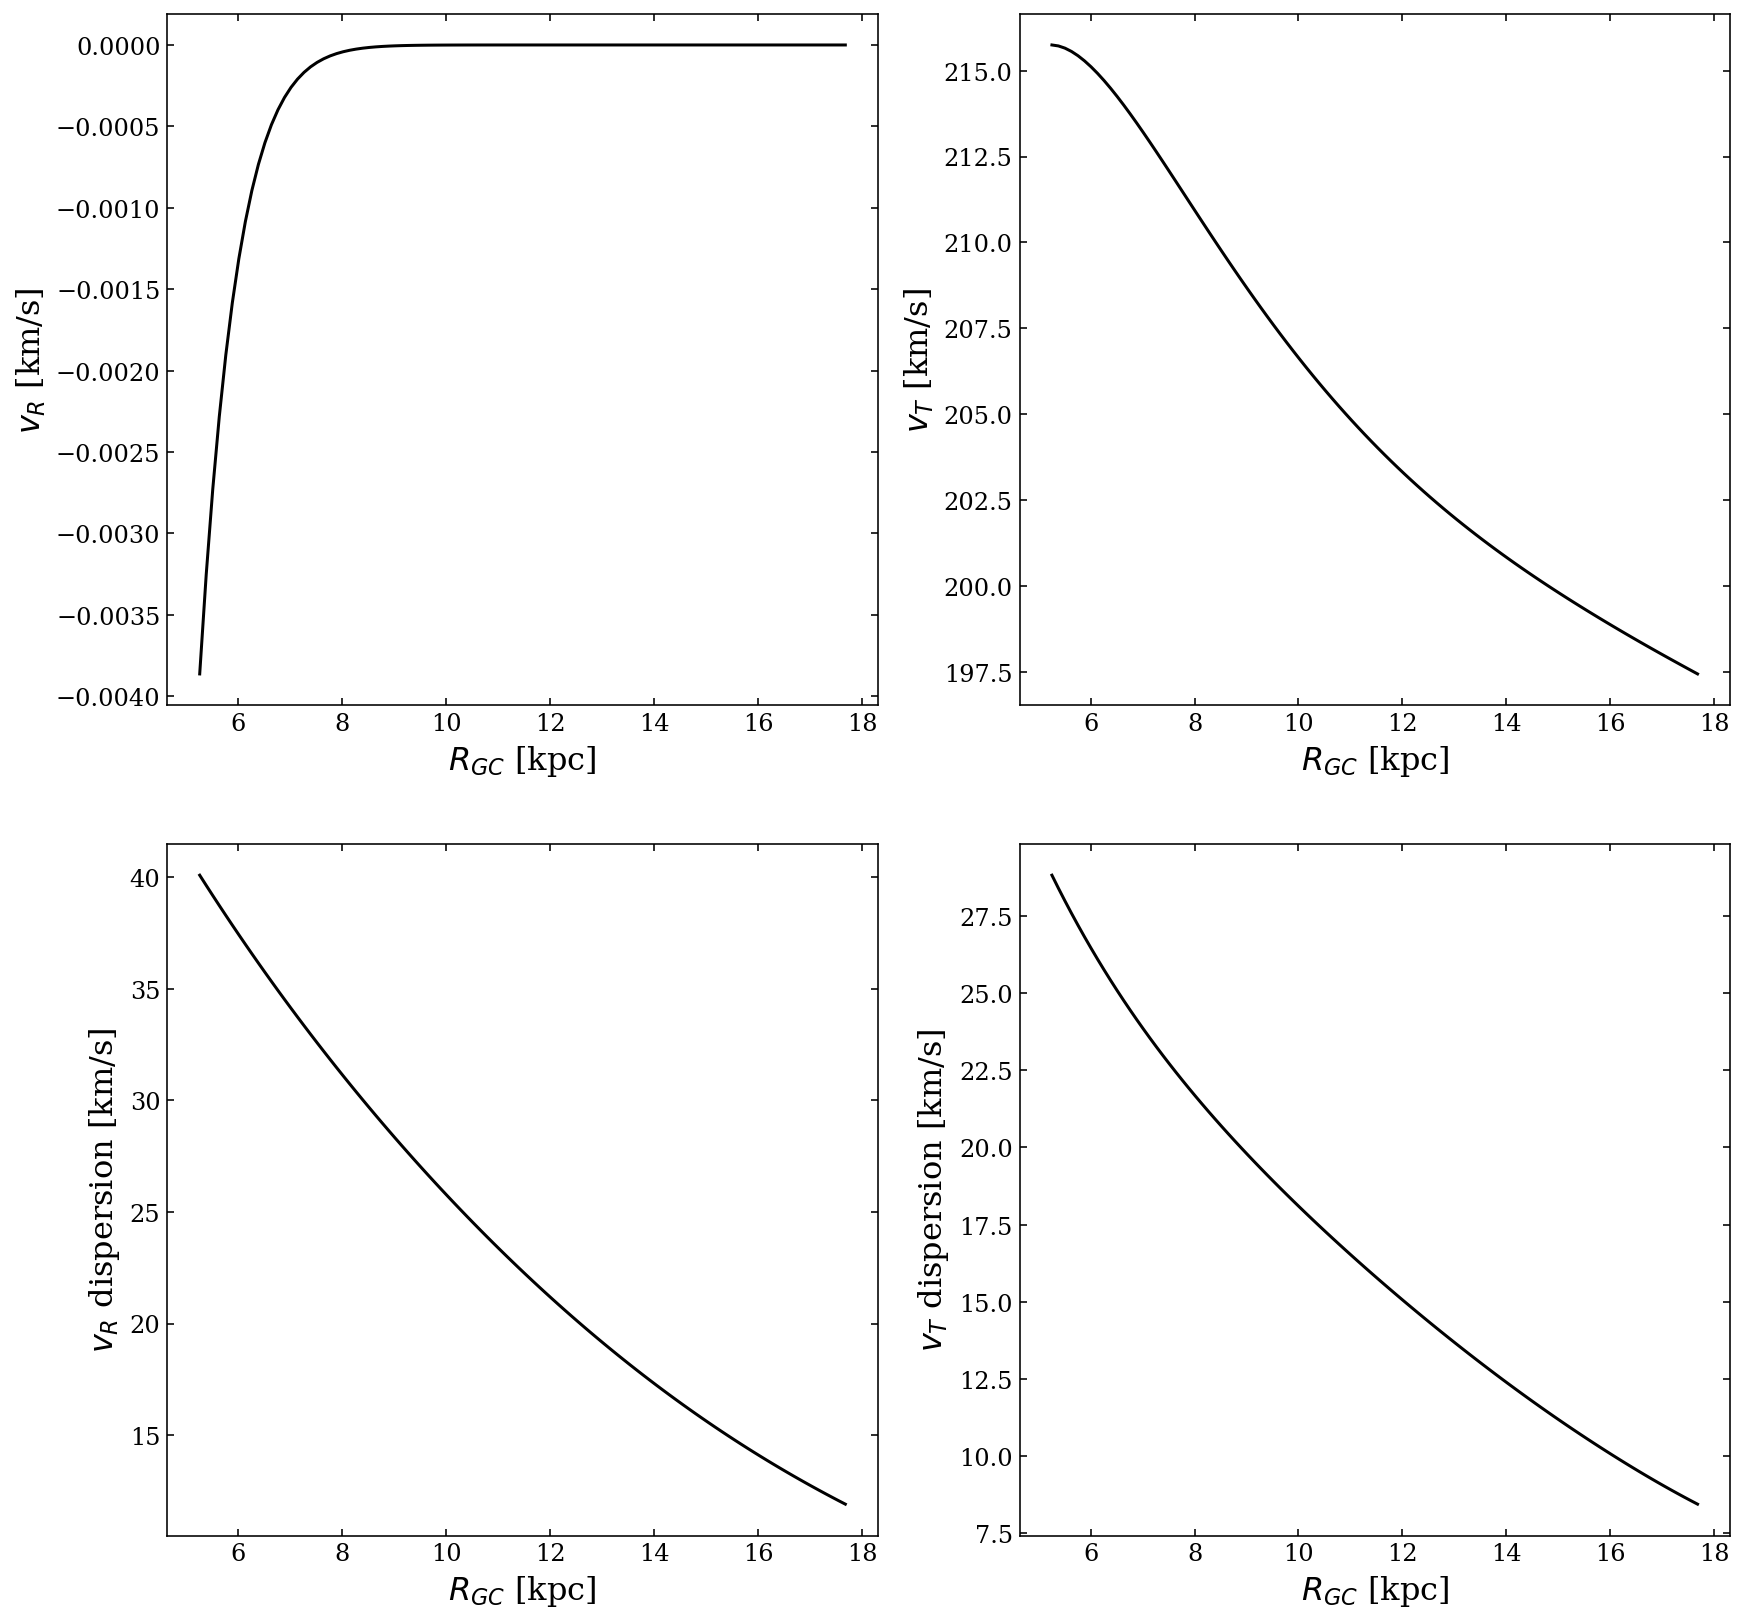

In [13]:
# Now plot this grid to make sure it looks sane
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(R_range, R_range_vr, color='Black')
ax1.set_xlabel(r'$R_{GC}$ [kpc]')
ax1.set_ylabel(r'$v_{R}$ [km/s]')

ax2.plot(R_range, R_range_vt, color='Black')
ax2.set_xlabel(r'$R_{GC}$ [kpc]')
ax2.set_ylabel(r'$v_{T}$ [km/s]')

ax3.plot(R_range, R_range_svr, color='Black')
ax3.set_xlabel(r'$R_{GC}$ [kpc]')
ax3.set_ylabel(r'$v_{R}$ dispersion [km/s]')

ax4.plot(R_range, R_range_svt, color='Black')
ax4.set_xlabel(r'$R_{GC}$ [kpc]')
ax4.set_ylabel(r'$v_{T}$ dispersion [km/s]')


plt.show()

## Make 2D map using radial values

In [14]:
for i in range(n_xbins):
    for j in range(n_ybins):
        R_cur = np.sqrt( np.square(gcx_range[i]) + np.square(gcy_range[j]) )
        where_close_R = np.argmin( np.abs( R_cur - R_range ) )
        vr_field[i,j] = R_range_vr[where_close_R]
        vt_field[i,j] = R_range_vt[where_close_R]
        svr_field[i,j] = R_range_svr[where_close_R]
        svt_field[i,j] = R_range_svt[where_close_R]
    ###j
###i

# Plot
Plot each of the following:
- Density of stars
- Galactocentric radial velocity
- Galactocentric tangential velocity
- Heliocentric radial velocity
- Proper motions
- B12 model

## Prepare

In [15]:
### Prepare for plotting

# Sun
x_sun = -8.125

## Stellar density

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10



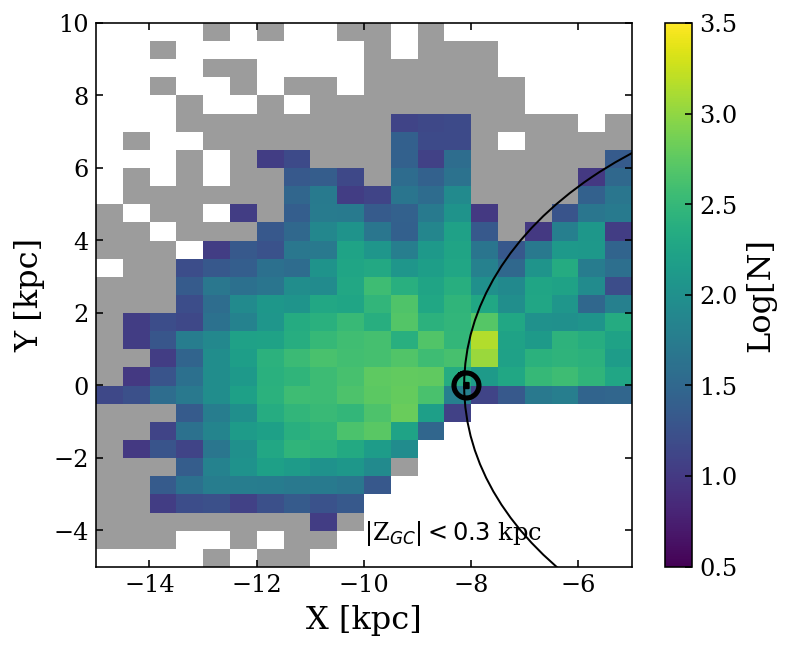

In [16]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

hist, xedges, yedges = np.histogram2d(gc_x, gc_y, bins=(n_xbins,n_ybins), range=bin_range)

# Find low-N bins. As long as histogram geometry remains the same this will be 
# used for greying out values.
where_low_N = np.where( (hist < 10) & (hist > 0) )
low_N_mask = np.zeros((n_xbins,n_ybins,4))
low_N_mask[:,:,3] = 0.0
low_N_mask[where_low_N[0],where_low_N[1],:3] = 100
low_N_mask[where_low_N[0],where_low_N[1],3] = 1.0

# Find 0-N bins. This will differentiate between no data and too little data
where_no_N = np.where( hist == 0 )
no_N_mask = np.zeros((n_xbins,n_ybins,4))
no_N_mask[:,:,3] = 0.0
no_N_mask[where_no_N[0],where_no_N[1],:3] = 1
no_N_mask[where_no_N[0],where_no_N[1],3] = 1.0

# Rotate to account for histogram -> plotting grid
hist = np.rot90(hist)

img = ax.imshow(np.log10(hist), interpolation='nearest',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               cmap='viridis', vmin=0.5, vmax=3.5)
low_N_img = ax.imshow(np.rot90(low_N_mask), interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
no_N_img = ax.imshow(np.rot90(no_N_mask), interpolation='nearest',
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

cbar = plt.colorbar(img)
ax.scatter(x_sun, 0, marker=r'$\odot$', color='Black', s=256)
orbit_circle = plt.Circle((0, 0), x_sun, edgecolor='Black', facecolor='None')
ax.add_artist(orbit_circle)

ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
cbar.set_label('Log[N]')
ax.annotate(z_select_text, xy=(0.5,0.05), xycoords='axes fraction')
ax.set_aspect('auto')

plt.show()
fig.savefig('plots/N_hist.pdf')
plt.close(fig)

# No output
pass;

## Tangential velocity

In [17]:
import importlib
importlib.reload(ast1501.fourier)

<module 'ast1501.fourier' from '../../src/ast1501/fourier.py'>

In [18]:
# First make the Gaia tangential velocity field
vt_hist_obs,_,_,_ = binned_statistic_2d(gc_x, gc_y, values=-gc_vT, statistic=np.average,
                                                      bins=(n_xbins,n_ybins), range=bin_range)

# Remove NaNs, wherever there is too few data, and where there is 0 data
where_nan = np.where( np.isnan(vt_hist_obs) )
vt_hist_obs[where_nan] = 0

# Now make the difference
vt_diff = vt_hist_obs - (vt_field+20)

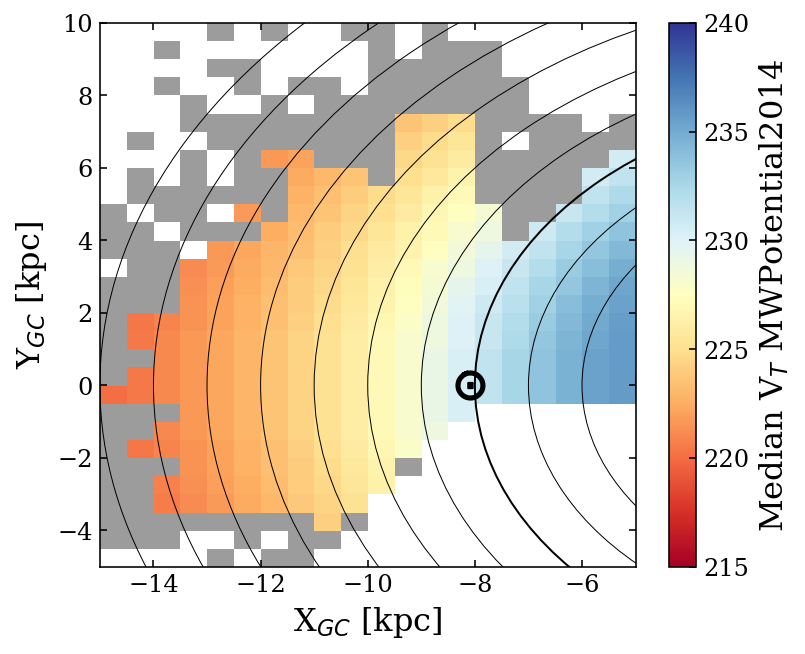

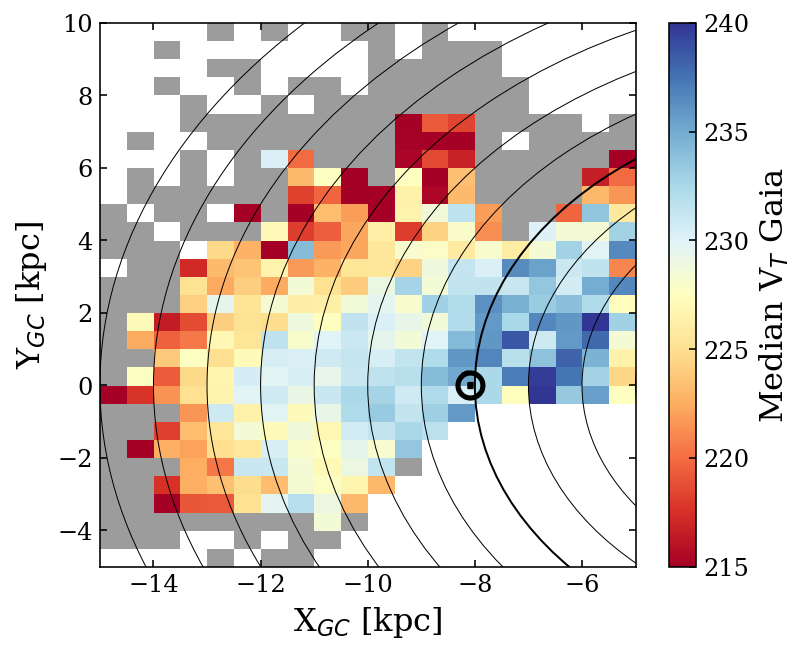

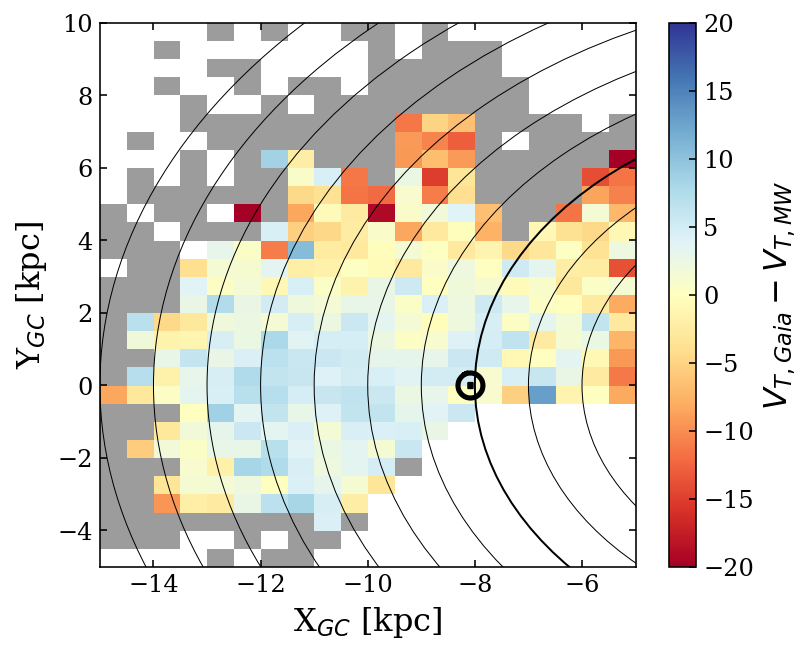

In [19]:
## Now plot

# MWPotential2014
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = plot_grid(vt_field+20, 240, 215, [x_lo,x_hi,y_lo,y_hi], low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median V$_{T}$ MWPotential2014')
ax.set_aspect('auto')

plt.show()
fig.savefig('plots/VT_med_hist_mwpot.pdf')
plt.close('all')

# Gaia
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = plot_grid(vt_hist_obs, 240, 215, [x_lo,x_hi,y_lo,y_hi], low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median V$_{T}$ Gaia')
ax.set_aspect('auto')

plt.show()
fig.savefig('plots/VT_med_hist_gaia.pdf')
plt.close('all')

# Difference
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = plot_grid(vt_diff, -20, 20, [x_lo,x_hi,y_lo,y_hi], low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'$V_{T,Gaia}-V_{T,MW}$ ')
ax.set_aspect('auto')

plt.show()
fig.savefig('plots/VT_diff.pdf')
plt.close('all')

## Make the power spectrum

In [20]:
import importlib
importlib.reload(ast1501.fourier)

<module 'ast1501.fourier' from '../../src/ast1501/fourier.py'>

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in sqrt



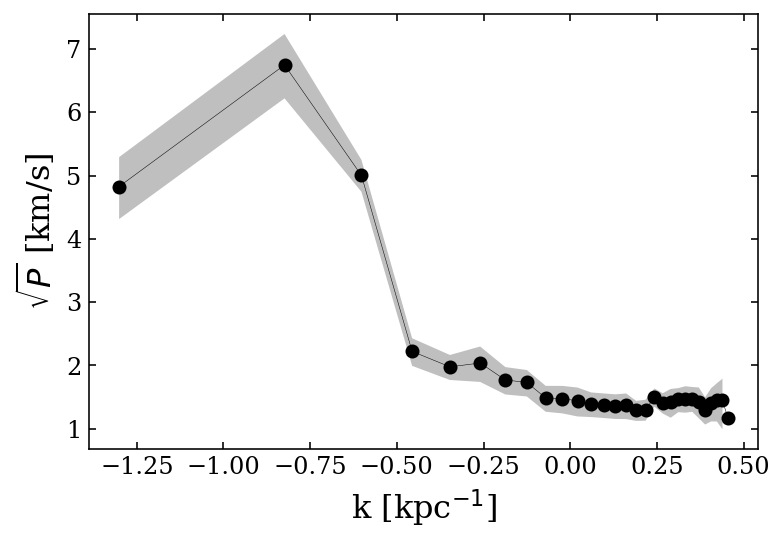

In [21]:
# Get the errors using a bootstrap method.

n_bs = 100
n_gaia = len(gc_x)
n_samp = int( n_gaia*1.0 )

for i in range(n_bs):
    
    # Take a random sub-sample of Gaia stars
    sample = np.random.randint(0,n_gaia,n_samp)
    samp_gc_x = gc_x[sample]
    samp_gc_y = gc_y[sample]
    samp_gc_vT = -gc_vT[sample]
    
    # First make a number map
    samp_hist, _, _ = np.histogram2d(samp_gc_x, samp_gc_y, bins=(n_xbins,n_ybins), range=bin_range)
    samp_where_low_N = np.where(samp_hist < 10)
    
    # Now make the Gaia tangential velocity field
    samp_vT_hist_obs, _,_,_ = binned_statistic_2d(samp_gc_x, samp_gc_y, values=samp_gc_vT, statistic=np.average,
                                                          bins=(n_xbins,n_ybins), range=bin_range)
    
    samp_vT_diff = samp_vT_hist_obs - (vt_field+20)
    
    # Zero out the map where there are bad values.
    samp_where_nan = np.where( np.isnan(samp_vT_diff) )
    samp_vT_diff[ samp_where_nan ] = 0
    samp_vT_diff[ samp_where_low_N ] = 0

    # Now make the FT
    samp_k_vT, samp_pk_vT, _ = ast1501.fourier.psd1d(samp_vT_diff,dx)
    
    if i == 0:
        bs_k_vT = np.zeros((n_bs, len(samp_k_vT)))
        bs_pk_vT = np.zeros((n_bs, len(samp_k_vT)))
        bs_k_vT[i] = samp_k_vT
        bs_pk_vT[i] = samp_pk_vT
    else:
        bs_k_vT[i] = samp_k_vT
        bs_pk_vT[i] = samp_pk_vT
    
    
bs_avg_pk_vT = np.average(bs_pk_vT, axis=0)
bs_std_pk_vT = np.std(bs_pk_vT, axis=0)

## Log
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot( np.log10(bs_k_vT[0]), 4*np.pi*np.sqrt(bs_avg_pk_vT), color='Black', linewidth=0.25, marker='o'  )
ax.fill_between( np.log10(bs_k_vT[0]), 4*np.pi*np.sqrt(bs_avg_pk_vT+bs_std_pk_vT), 
                4*np.pi*np.sqrt(bs_avg_pk_vT-bs_std_pk_vT), alpha=0.5, facecolor='Grey' )
ax.set_xlabel(r'k [kpc$^{-1}$]')
ax.set_ylabel(r'$\sqrt{P}$ [km/s]')

plt.show()
plt.close('all')

## Radial velocity

In [22]:
# First make the Gaia tangential velocity field
vr_hist_obs, _,_,_ = binned_statistic_2d(gc_x, gc_y, values=gc_vR, statistic=np.average,
                                                      bins=(n_xbins,n_ybins), range=bin_range)
where_nan = np.where( np.isnan(vr_hist_obs) )
vr_hist_obs[where_nan] = 0

# Now make the difference
vr_diff = vr_hist_obs - (vr_field)

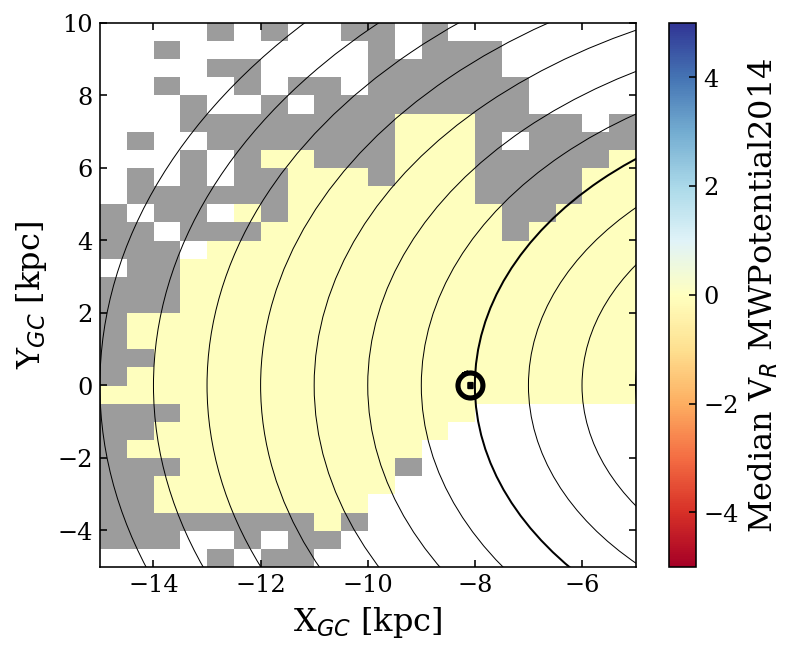

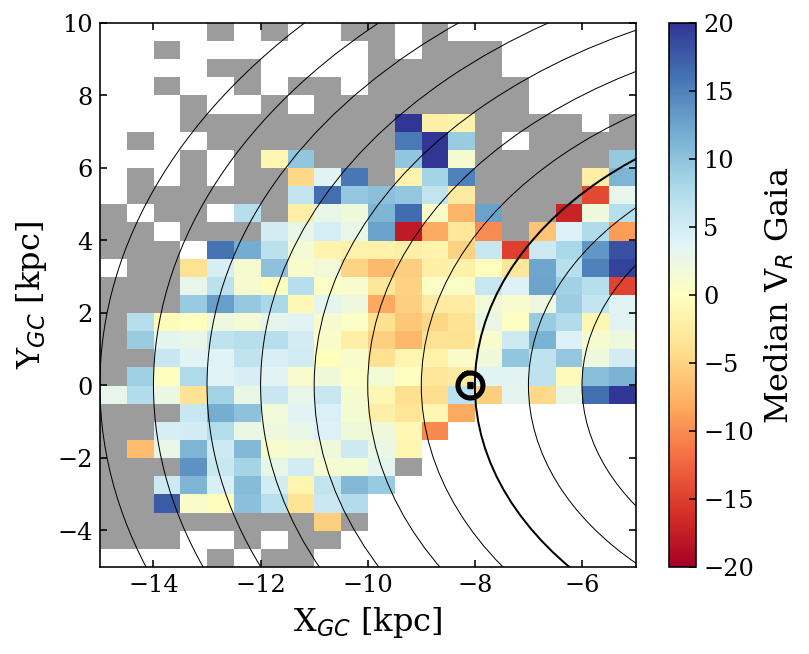

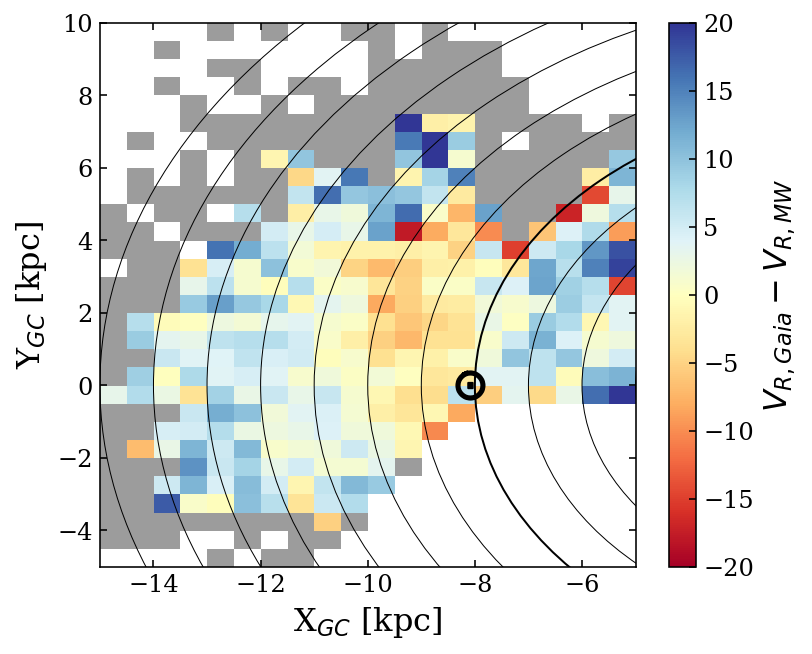

In [23]:
## Now plot

# MWPotential2014
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = plot_grid(vr_field, -5, 5, [x_lo,x_hi,y_lo,y_hi], low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median V$_{R}$ MWPotential2014')
ax.set_aspect('auto')

plt.show()
fig.savefig('plots/VR_med_hist_mwpot.pdf')
plt.close('all')

# Gaia
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = plot_grid(vr_hist_obs, -20, 20, [x_lo,x_hi,y_lo,y_hi], low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'Median V$_{R}$ Gaia')
ax.set_aspect('auto')

plt.show()
fig.savefig('plots/VR_med_hist_gaia.pdf')
plt.close('all')

# Difference
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

fig, ax, cbar = plot_grid(vr_diff, -20, 20, [x_lo,x_hi,y_lo,y_hi], low_N_mask, no_N_mask, 'RdYlBu')

cbar.set_label(r'$V_{R,Gaia}-V_{R,MW}$ ')
ax.set_aspect('auto')

plt.show()
fig.savefig('plots/VT_diff.pdf')

## Make the power spectrum

In [24]:
# import importlib
# importlib.reload(ast1501.fourier)

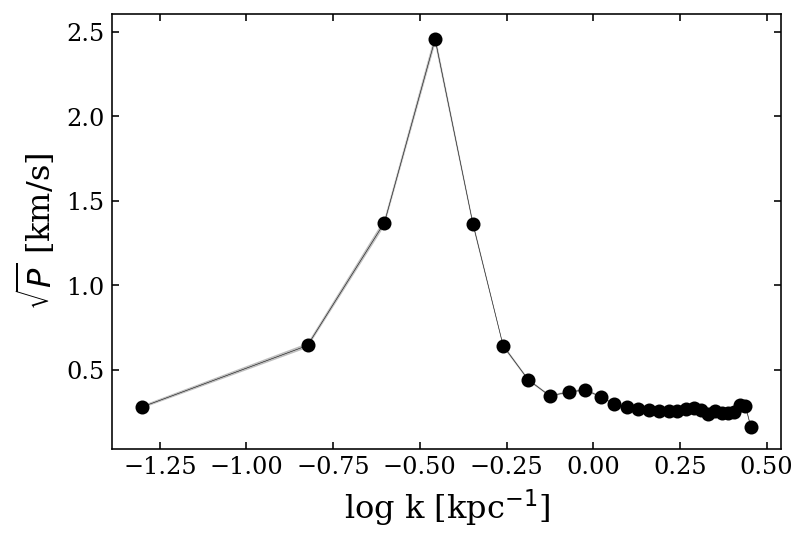

In [27]:
n_bs = 100
n_gaia = len(gc_x)
n_samp = int( n_gaia*1. )

for i in range(n_bs):
    
    # Take a random sub-sample of Gaia stars
    sample = np.random.randint(0,n_gaia,n_samp)
    samp_gc_x = gc_x[sample]
    samp_gc_y = gc_y[sample]
    samp_gc_vR = gc_vR[sample]
    
    # First make a number map
    samp_hist, _, _ = np.histogram2d(samp_gc_x, samp_gc_y, bins=(n_xbins,n_ybins), range=bin_range)
    samp_where_low_N = np.where(samp_hist < 10)
    
    # First make the Gaia tangential velocity field
    samp_vR_hist_obs, _,_,_ = binned_statistic_2d(samp_gc_x, samp_gc_y, values=samp_gc_vR, statistic=np.average,
                                                          bins=(n_xbins,n_ybins), range=bin_range)
    samp_where_nan = np.where( np.isnan(samp_vR_hist_obs) )
    samp_vR_hist_obs[ samp_where_nan ] = 0
    samp_vR_hist_obs[ samp_where_low_N ] = 0
    samp_vR_hist_obs[ samp_where_low_N ] = 0

    # Now make the FT
    samp_k_vR, samp_pk_vR, _ = ast1501.fourier.psd1d(samp_vR_hist_obs,dx)
    
    if i == 0:
        bs_k_vR = np.zeros((n_bs, len(samp_k_vR)))
        bs_pk_vR = np.zeros((n_bs, len(samp_k_vR)))
        bs_k_vR[i] = samp_k_vR
        bs_pk_vR[i] = samp_pk_vR
    else:
        bs_k_vR[i] = samp_k_vR
        bs_pk_vR[i] = samp_pk_vR
    
    
bs_avg_pk_vR = np.average(bs_pk_vR, axis=0)
bs_std_pk_vR = np.std(bs_pk_vR, axis=0)

## Log
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot( np.log10(bs_k_vR[0]), 4*np.pi*bs_avg_pk_vR, color='Black', linewidth=0.25, marker='o'  )
ax.fill_between( np.log10(bs_k_vR[0]), 4*np.pi*bs_avg_pk_vR+bs_std_pk_vR, 
                4*np.pi*bs_avg_pk_vR-bs_std_pk_vR, alpha=0.5, facecolor='Grey' )
ax.set_xlabel(r'log k [kpc$^{-1}$]')
ax.set_ylabel(r'$\sqrt{P}$ [km/s]')

plt.show()
plt.close('all')
    